Step 1: Tabular Q-learning with SoftMax policy

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [9]:
def my_softmax(values: np.ndarray, T=1.):
    # Subtract max for numerical stability
    shifted_values = values - np.max(values)
    exp_values = np.exp(shifted_values / T)
    probas = exp_values / np.sum(exp_values)
    return probas

In [10]:
test_data = np.arange(5)
print("test_data:", test_data)

for temp in [0.1, 0.5, 1, 5]:
    print(f"\nTesting temp={temp}")
    
    local_softmax = my_softmax(test_data, T=temp)
    print("local_softmax:", local_softmax)
    
    with torch.no_grad():
        torch_softmax = torch.softmax(torch.from_numpy(test_data)/temp, dim=-1)
    print("torch_softmax:", torch_softmax.numpy())
    
    print("Are they close?", np.allclose(local_softmax, torch_softmax.numpy()))
    
    assert np.allclose(local_softmax, torch_softmax.numpy())
    print(f'Passed for temp={temp}')

test_data: [0 1 2 3 4]

Testing temp=0.1
local_softmax: [4.24816138e-18 9.35719813e-14 2.06106005e-09 4.53978686e-05
 9.99954600e-01]
torch_softmax: [4.248161e-18 9.357198e-14 2.061060e-09 4.539787e-05 9.999546e-01]
Are they close? True
Passed for temp=0.1

Testing temp=0.5
local_softmax: [2.90075868e-04 2.14338686e-03 1.58376057e-02 1.17024957e-01
 8.64703974e-01]
torch_softmax: [2.9007587e-04 2.1433870e-03 1.5837606e-02 1.1702495e-01 8.6470395e-01]
Are they close? True
Passed for temp=0.5

Testing temp=1
local_softmax: [0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
torch_softmax: [0.01165623 0.03168492 0.08612854 0.23412165 0.6364086 ]
Are they close? True
Passed for temp=1

Testing temp=5
local_softmax: [0.12885125 0.15737927 0.19222347 0.23478228 0.28676373]
torch_softmax: [0.12885125 0.15737927 0.19222347 0.2347823  0.28676373]
Are they close? True
Passed for temp=5


In [11]:
import torch
test_data = np.arange(5)
for temp in [0.1, 0.5, 1, 5]:
    local_softmax = my_softmax(test_data, T=temp)
    with torch.no_grad():
        torch_softmax = torch.softmax(torch.from_numpy(test_data)/temp, dim=-1)
    assert np.allclose(local_softmax, torch_softmax.numpy())
    print(f'Passed for temp={temp}')

Passed for temp=0.1
Passed for temp=0.5
Passed for temp=1
Passed for temp=5


Text(0.5, 1.0, 'Example softmax with temp = 1')

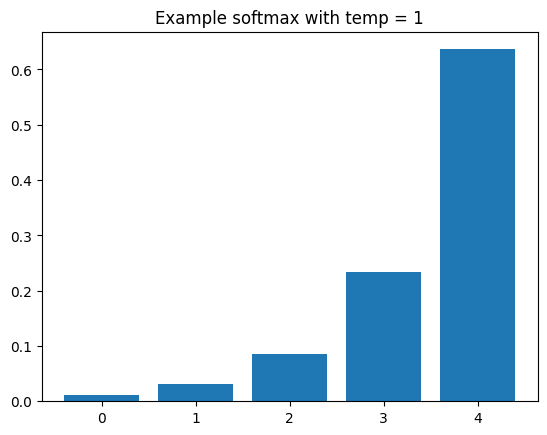

In [12]:
temp = 1
plt.bar(test_data, my_softmax(test_data, T=temp))
plt.title(f'Example softmax with temp = {temp}')

In [ ]:
import random
from collections import defaultdict


class QLearningAgent:
    def __init__(self, alpha, discount, get_legal_actions, temp=1.):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.discount = discount
        self.temp = temp

    def get_qvalue(self, state, action):
        """Returns Q(state,action)"""
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """Sets the Qvalue for [state,action] to the given value"""
        self._qvalues[state][action] = value

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # YOUR CODE HERE
        # Calculate the approximation of value function V(s).
        q_values = [self.get_qvalue(state, action) for action in possible_actions]
        value = np.max(q_values)

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        # YOUR CODE HERE
        # Calculate the updated value of Q(s, a).
        current_q = self.get_qvalue(state, action)
        next_value = self.get_value(next_state)
        qvalue = (1 - learning_rate) * current_q + learning_rate * (reward + gamma * next_value)

        self.set_qvalue(state, action, qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # YOUR CODE HERE
        # Choose the best action wrt the qvalues.
        q_values = [self.get_qvalue(state, action) for action in possible_actions]
        best_action = possible_actions[np.argmax(q_values)]

        return best_action

    def get_softmax_policy(self, state):
        """
        Compute all actions probabilities in the current state according
        to their q-values using softmax policy.

        Actions probability should be computed as
        p(a_i|s) = softmax([q(s, a_1), q(s, a_2), ... q(s, a_k)])_i
        Softmax temperature is set to `self.temp`.
        See the formula in the notebook for more details
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # YOUR CODE HERE
        # Compute all actions probabilities in the current state using softmax
        q_values = np.array([self.get_qvalue(state, action) for action in possible_actions])
        probabilities = my_softmax(q_values, self.temp)

        return probabilities


    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        Select actions according to softmax policy.

        Note: To pick randomly from a list, use np.random.choice(..., p=actions_probabilities)
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # YOUR CODE HERE
        # Select the action to take in the current state according to the policy
        probabilities = self.get_softmax_policy(state)
        chosen_action = np.random.choice(possible_actions, p=probabilities)
        return chosen_action

Try on taxi

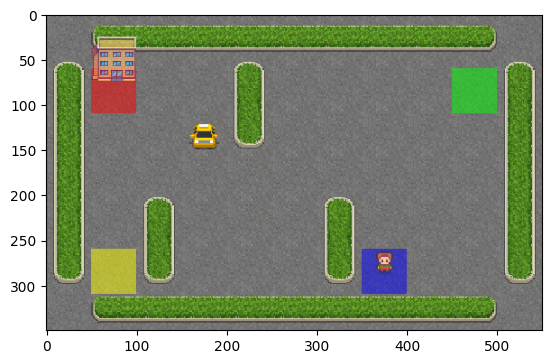

In [16]:
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="rgb_array")

n_actions = env.action_space.n
s, _ = env.reset()
plt.imshow(env.render())
agent = QLearningAgent(alpha=0.5, discount=0.99, get_legal_actions=lambda s: range(n_actions))

In [17]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [18]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))

    if i % 100 == 0:
        clear_output(True)
        plt.title("mean reward = {:.1f}".format(np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

AssertionError: 